### Domain:  Image Captioning

### Dataset: Flickr8k_Database
### Question: Train a model and Predict the caption for image using LSTM and CNN (transfer learing of  "InceptionV3" and weights "imagenet")


#### Corpus Bleu Score: 51 %

#### Importing liberaries 

In [1]:
import numpy as np
import tensorflow as tf
import re
from pickle import dump, load
from os import listdir
from numpy import array, argmax


from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

from keras.layers.merge import add

from nltk.translate.bleu_score import corpus_bleu
import os

from tensorflow.keras.utils import to_categorical

from datetime import datetime

from tensorflow.keras.utils import plot_model


In [2]:
from IPython.display import Image, display

## 1. Data Preprocessing 

#### For the required files, saving their path to variables

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -ltr "/content/drive/My Drive/Dataset/Seq_Learn_Assign_3"

total 105866
-rw------- 1 root root 41399186 Oct 24  2019 Hindi_English_Truncated_Corpus.csv
drwx------ 2 root root     4096 Apr 19 13:11 Flickr8k_text
drwx------ 2 root root     4096 Apr 19 13:30 Flicker8k_images
-rw------- 1 root root 66999214 Apr 25 01:20 features_Flickr8k_images_new.pkl


In [5]:
all_captions_file = '/content/drive/My Drive/Dataset/Seq_Learn_Assign_3/Flickr8k_text/Flickr8k.token.txt'
train_list_file   = '/content/drive/My Drive/Dataset/Seq_Learn_Assign_3/Flickr8k_text/Flickr_8k.trainImages.txt'
test_list_file    = '/content/drive/My Drive/Dataset/Seq_Learn_Assign_3/Flickr8k_text/Flickr_8k.devImages.txt'
images_dir        = '/content/drive/My Drive/Dataset/Seq_Learn_Assign_3/Flicker8k_images/'

#### Model summary for InceptionV3 to know the output shape : 2048

In [6]:
model_Inception_V3 = InceptionV3(weights='imagenet')
print(model_Inception_V3.summary())

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

#### Function to access the InceptionV3 model object without last activation layer.

In [7]:
def get_Inception_V3_Model():
    model = InceptionV3(weights='imagenet')
    # remove the last Softmax layer, the 2nd last layer gives a 2048 vector
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    return model

#### Function to extract the features from each image in the directory of Flickr8k dataset


In [8]:
def extract_features(directory):
    model_Inception_V3 = get_Inception_V3_Model()
    features = dict()
    idx = 0
    i = 0
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))       
        image = img_to_array(image) # convert the image pixels to a numpy array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model_Inception_V3.predict(image, verbose=0)
        feature = np.reshape(feature, feature.shape[1])
        image_id = name.split('.')[0]
        features[image_id] = feature
        idx += 1
        if (idx % 100 == 0):
            print(datetime.now().time(),' - Image:',idx,'--','>%s' % name)
            #print("Time: ", datetime.now().time())
    return features

#### Call the above (extract_features) function to extract the features from all images of directory

Save the features in ppickle fils for further use

In [9]:
features = extract_features(images_dir)
print('Extracted Features: %d' % len(features))
pkl_file = '/content/drive/My Drive/Dataset/Seq_Learn_Assign_3/features_Flickr8k_images_new.pkl'

dump(features, open(pkl_file, 'wb'))

11:39:05.606379  - Image: 100 -- >2541701582_0a651c380f.jpg
11:39:13.012526  - Image: 200 -- >3427118504_93126c83e0.jpg
11:39:20.430281  - Image: 300 -- >3601978895_9fec23ce0c.jpg
11:39:27.844705  - Image: 400 -- >460973814_5eacd1ced4.jpg
11:39:35.591604  - Image: 500 -- >3344632789_af90d54746.jpg
11:39:43.075031  - Image: 600 -- >2525232298_cf42d415ab.jpg
11:39:50.499797  - Image: 700 -- >566794036_60f7acdf35.jpg
11:39:57.915586  - Image: 800 -- >254901702_67ada9867c.jpg
11:40:05.648382  - Image: 900 -- >3167379087_927ff05a35.jpg
11:40:13.105027  - Image: 1000 -- >1287982439_6578006e22.jpg
11:40:20.801219  - Image: 1100 -- >839295615_bb9baf2f95.jpg
11:40:28.228549  - Image: 1200 -- >2522809984_2e8a7df4fb.jpg
11:40:35.703069  - Image: 1300 -- >1500853305_0150615ce9.jpg
11:40:43.163934  - Image: 1400 -- >1067675215_7336a694d6.jpg
11:40:50.951055  - Image: 1500 -- >1620397000_3883e3ecd3.jpg
11:40:58.460613  - Image: 1600 -- >937559727_ae2613cee5.jpg
11:41:05.944758  - Image: 1700 -- >299

#### Function to load the image features from the saved pickle file

* Read the file and each images_id and load the features from pickle.

In [10]:
def load_images_features(file_features, file_imageids):
  length=0
  feat = dict()
  with open(file_imageids,'r') as f:
    lines = f.read()
  with open(file_features,'rb') as f:
    allfeatures = load(f) 
  for line in lines.split('\n'):
    if len(line)<2:
      continue
    image_id = line.split('.')[0]
    feat[image_id] = allfeatures[image_id]
    length+=1
  print('Number of instances:', length)
  return feat

### Creating Train and Test features disctionary using "load_images_features" function

In [11]:
train_features = load_images_features(pkl_file,train_list_file)
test_features  = load_images_features(pkl_file,test_list_file)

Number of instances: 6000
Number of instances: 1000


In [12]:
train_features['3352791995_8db4979aca'].shape

(2048,)

#### Function to clean the image description 

In [13]:
def clean_description(desc):
    d = desc.lower()
    # keep only those words which have only alphabets, remove punctuations, digits,etc
    d = re.sub(r'\w*[^a-z\s<>]+\w*','',d)
    # removing unnecessary white spaces
    d = d.split()
    d = ' '.join(d)
    return d

#### Function to load the description for images from txt file.

In [14]:
def load_descriptions(file):
    with open(file,'r') as f:
      lines = f.read()
    mapping = dict()
    for line in lines.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id = tokens[0].split('.')[0]
        image_desc = clean_description(' '.join(tokens[1:]))
        # add special <start> and <end> token to every caption
        image_desc = '<start> '+ image_desc +' <end>'
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

#### Create a dictionary of description for images from Flickr8k.token.txt file

In [15]:
all_captions_dict = load_descriptions(all_captions_file)
print(len(all_captions_dict))

8092


In [16]:
all_captions_dict['1001773457_577c3a7d70']

['<start> a black dog and a spotted dog are fighting <end>',
 '<start> a black dog and a dog playing with each other on the road <end>',
 '<start> a black dog and a white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

#### Function to create vacubulary of words for all loaded description 

In [17]:
def to_vocabulary(captions_dict):
    # build a list of all description strings
    vocab = set()
    for key, descr_list in captions_dict.items():
        [vocab.update(d.split()) for d in descr_list]
    return vocab

#### Creating Vacubulary of words 

In [18]:
vocab = to_vocabulary(all_captions_dict)
print('Original Vocabulary Size: %d' % len(vocab))

Original Vocabulary Size: 8371


### Function to create train and test captions disctionary

In [19]:
def load_text(all_captions_dict, list_file):
  #loads the text data corresponding to train and test images
  length=0
  captions_dict = dict()
  with open(list_file,'r') as f:
    lines = f.read()
  for line in lines.split('\n'):
    if len(line)<2:
      continue
    image_id = line.split('.')[0]
    captions_dict[image_id] = all_captions_dict.get(image_id)
    length+=1

  print('Number of image ids:', length)
  return captions_dict

### Create Train and Test caption dictionaries 

**train_captions_dict** and **test_captions_dict**<br> 

In [20]:
train_captions_dict = load_text(all_captions_dict,train_list_file)
test_captions_dict = load_text(all_captions_dict,test_list_file)

Number of image ids: 6000
Number of image ids: 1000


#### Function to convert disctionary to list 

In [21]:
def to_lines(captions_dict):
    all_desc = list()
    for key in captions_dict.keys():
        [all_desc.append(d) for d in captions_dict[key]]
    return all_desc

#### Function to tokenize the dictionary 

In [22]:
def create_tokenizer(captions_dict):
    lines = to_lines(captions_dict)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#### Function to find max_length of a caption

calculate the length of the description with the most words

In [23]:
def get_max_length(captions_dict):
    lines = to_lines(captions_dict)
    return max(len(d.split()) for d in lines)

#### Find the max lenth of word in captions and vacubulary size 

In [24]:
max_length = get_max_length(train_captions_dict)

tokenizer = create_tokenizer(train_captions_dict)

print('Maximum length of caption in training data:', max_length)

vocab_size = len(tokenizer.word_index) + 1

print('Vacubulary Size:',vocab_size)

Maximum length of caption in training data: 36
Vacubulary Size: 7275


### Function to create sequences of images

In [25]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    x1, x2, y = list(), list(), list()
    x1, x2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            x1.append(photo)
            x2.append(in_seq)
            y.append(out_seq)
    return array(x1), array(x2), array(y)

### Create data generator function to use in model.

In [26]:
def data_generator(captions_dict, image_features, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in captions_dict.items():
            photo = image_features[key]#[0]

            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq] , out_word

In [27]:
# Testing for data generator function 

i = 1

generator = data_generator(train_captions_dict, train_features, tokenizer, max_length, vocab_size)

for [in_img, in_seq], out_word in generator:
    i += 1
    if i > 5:
        break
        
    print(in_img.shape, in_seq.shape, out_word.shape)

(50, 2048) (50, 36) (50, 7275)
(55, 2048) (55, 36) (55, 7275)
(64, 2048) (64, 36) (64, 7275)
(51, 2048) (51, 36) (51, 7275)


## 2. Defining the model

In [28]:
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Combine inputs together [image, seq] and output is [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # print(model.summary())
    
    return model

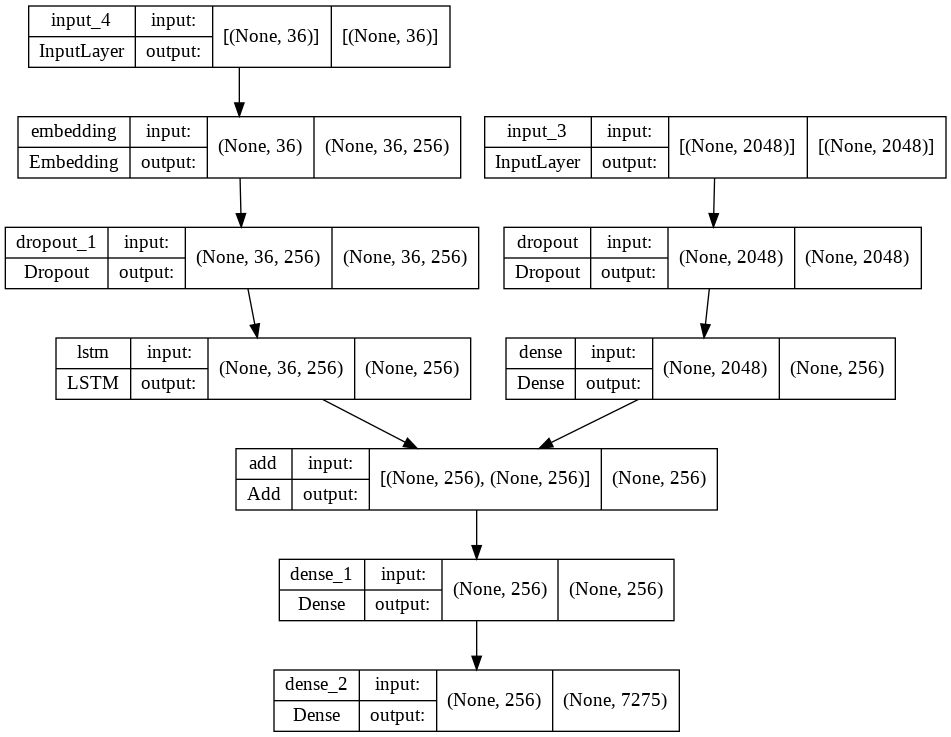

In [29]:
model = define_model(vocab_size, max_length)

plot_model(model, to_file='model.png', show_shapes=True)

## 3. Model Training


In [30]:
# train the model, run epochs manually and save after each epoch
epochs = 5
steps = len(train_captions_dict)
for i in range(5):
    # generate the data
    generator = data_generator(train_captions_dict, train_features, tokenizer, max_length, vocab_size)
    # fit the data
    model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
        
    #model.fit_generator(generator=train_generator, steps_per_epoch=len(encoded_train_images), epochs=1)
    # save the model
    model.save('model_18_8_2021_' + str(i) + '.h5')

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


6000/6000 [==============================] - 674s 111ms/step - loss: 3.9859
Epoch 2/5
6000/6000 [==============================] - 665s 111ms/step - loss: 3.2635
Epoch 3/5
6000/6000 [==============================] - 669s 112ms/step - loss: 3.0251
Epoch 4/5
6000/6000 [==============================] - 668s 111ms/step - loss: 2.8780
Epoch 5/5
6000/6000 [==============================] - 663s 110ms/step - loss: 2.7783
Epoch 1/5
6000/6000 [==============================] - 661s 110ms/step - loss: 2.6990
Epoch 2/5
6000/6000 [==============================] - 664s 111ms/step - loss: 2.6403
Epoch 3/5
6000/6000 [==============================] - 662s 110ms/step - loss: 2.5917
Epoch 4/5
6000/6000 [==============================] - 657s 110ms/step - loss: 2.5536
Epoch 5/5
6000/6000 [==============================] - 644s 107ms/step - loss: 2.5233
Epoch 1/5
6000/6000 [==============================] - 642s 107ms/step - loss: 2.4978
Epoch 2/5
6000/6000 [==============================] - 646s 108m

## 4. Prediction: 

#### Function to return  the word from specific index from tokenizer 

In [31]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

### Function to predict and generate the description for image

In [32]:
def generate_desc(model, tokenizer, photo, max_length):
    
    # feed the input with <start>
    in_text = '<start>'
    
    for i in range(max_length):
        
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the input sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        
        # convert softmax probability to integer
        yhat = argmax(yhat)
        
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        
        # stop if we cannot map the word
        if word is None:
            break
            
        # append as input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'end':
            break
            
    return in_text

### Choose & load the best trained model for prediction

In [33]:
model_pred = define_model(vocab_size, max_length)
model_pred.load_weights('model_18_8_2021_2.h5')

###### Prediction for image: 3346918203_986dca6641.jpg

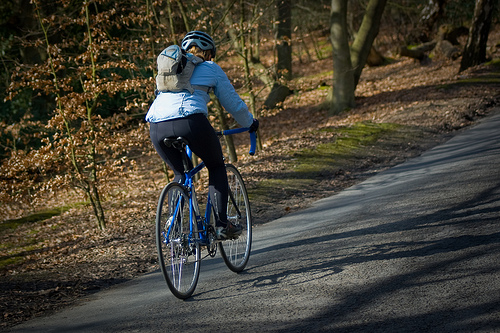

Caption prediction for above Image:  a man in a blue helmet and helmet is jumping over a dirt ramp.



In [36]:
imeg = images_dir + '/3346918203_986dca6641.jpg'
display(Image(imeg))
# load the image from test fetures
photo = test_features['3346918203_986dca6641']

# reshape image from (2048,) to (1, 2048) for preddiction
#print('before reshape: ',photo.shape)
photo = photo.reshape((1, photo.shape[0]))
#print('after reshape: ',photo.shape, end="\n\n")

caption = generate_desc(model_pred, tokenizer, photo, max_length)
caption =  (caption.replace('<start> ','')).replace(' end','.')
print('Caption prediction for above Image: ',caption, end="\n\n")

### Predict caption for first 7 images from test image features 

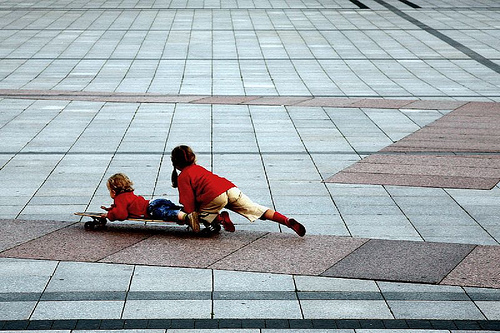

Prediction: a man in a red shirt and a black shirt is standing in front of a crowd.



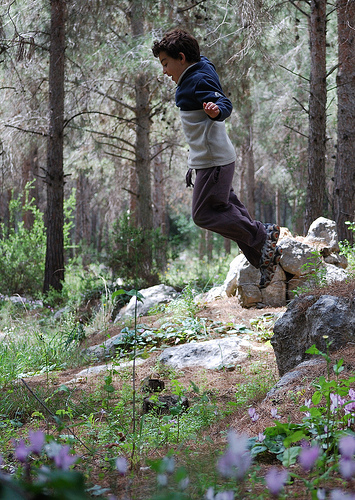

Prediction: a man in a red shirt and jeans is on a skateboard in the air.



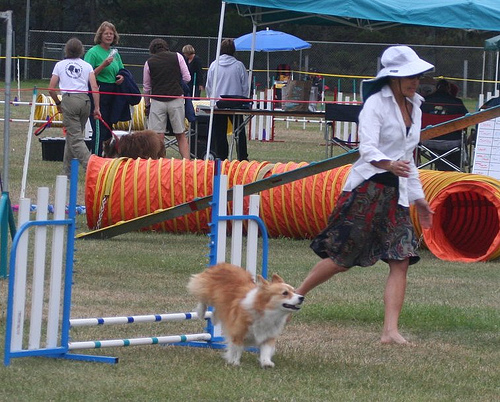

Prediction: a dog is running on the grass.



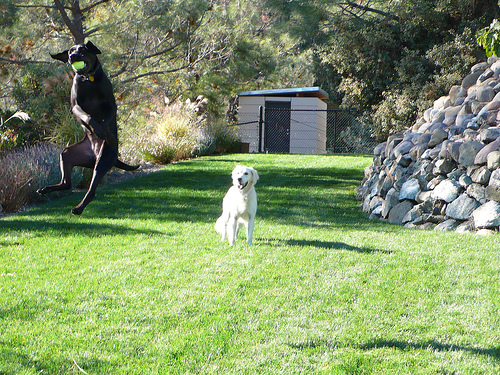

Prediction: a dog is running through the grass.



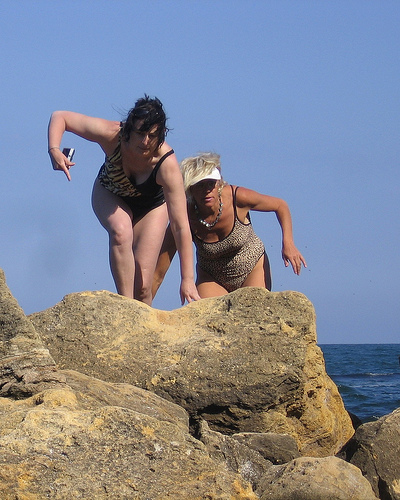

Prediction: a little girl in a pink shirt is jumping into a pool.



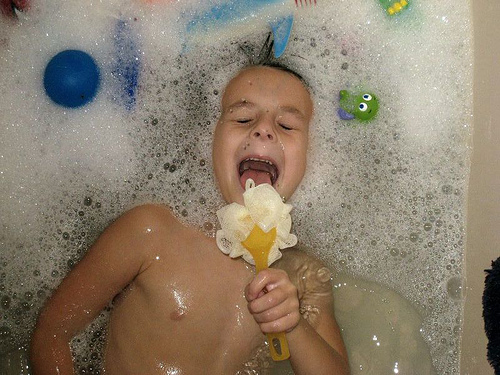

Prediction: a little girl in a pink shirt is jumping into a pool.



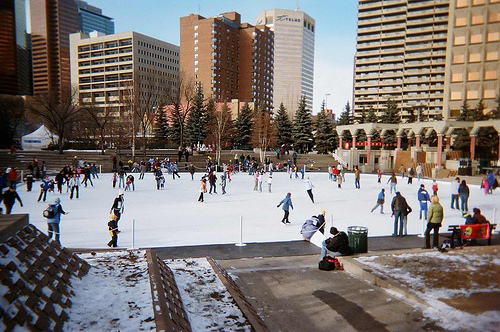

Prediction: a man in a blue helmet and a helmet is riding a bike on a dirt track.



In [37]:
idx =0;
for img in test_features.keys():
    if idx < 7:
        idx+=1
        
        photo = test_features[img]
        photo = photo.reshape((1, photo.shape[0]))
        caption = generate_desc(model_pred, tokenizer, photo, max_length)
        caption =  (caption.replace('<start> ','Prediction: ')).replace(' end','.')
        img_path = os.path.join(images_dir, img+'.jpg')
        pic = Image(filename = img_path, width = 200, height = 100)
        #display(Image(img_path))
        display(pic)
        print(caption, end="\n\n")

## 5. Evaluate the model for test feature

In [38]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        photo = photos[key]
        photo = photo.reshape((1, photo.shape[0]))
        yhat = generate_desc(model, tokenizer, photo, max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('Corpus Bleu Score: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

In [39]:
evaluate_model(model_pred, test_captions_dict, test_features, tokenizer, max_length)

Corpus Bleu Score: 0.473902
